In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation
import random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
mindur_toaccountforZ4 = config.mindur_toaccountforZ4
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# Download data

In [5]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,7,25)]
print(df_daily.shape)
df_daily.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


#daily var IN BETWEEN CHECKS
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily__pen8TEST_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

In [6]:
print(df_daily[df_daily['vertical_travel_distance_dawn']==0].shape)
print(df_daily[df_daily['vertical_travel_distance_dawn']>0].shape)

(33231, 70)
(300, 70)


In [7]:
df_daily[['list_ZALL','mid_cum_Z4_sec','list_of_zones','list_of_durations']]

,list_ZALL,mid_cum_Z4_sec,list_of_zones,list_of_durations
0,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",NaN,['5_Zone'],[32400.0]
1,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",1474.0,"['5_Zone', '3_Zone', '4_Zone', '5_Zone']","[532.0, 780.0, 325.0, 30763.0]"
2,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",520.0,"['3_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zo...","[225.0, 206.0, 24.0, 130.0, 31815.0]"
3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,"['3_Zone', '2_Zone', '3_Zone', '2_Zone', '3_Zo...","[1059.0, 13499.0, 1854.0, 9057.0, 1502.0, 1829.0]"
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,"['2_Zone', '3_Zone', '2_Zone', '3_Zone', '5_Zo...","[4325.0, 2707.0, 7088.0, 1977.0, 3930.0, 7170...."
...,...,...,...,...
39377,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",15088.0,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[676.0, 45.0, 9.0, 4.0, 1088.0, 31.0, 107.0, 5..."
39378,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",13686.0,"['3_Zone', '4_Zone', '3_Zone', '2_Zone', '3_Zo...","[719.0, 129.0, 69.0, 1056.0, 201.0, 27.0, 590...."
39379,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",13768.0,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[746.0, 26.0, 46.0, 83.0, 1054.0, 268.0, 735.0..."
39380,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",13599.0,"['4_Zone', '3_Zone', '2_Zone', '3_Zone', '2_Zo...","[730.0, 184.0, 1089.0, 182.0, 399.0, 78.0, 156..."


In [8]:
print(list(df_daily.columns))

['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'nestboxes_related_behavior', 'list_of_zones', 'list_ZALL', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_d

# Quick transformation - Could be added in UTILS if another run

In [24]:
#weekdays
dico_d_week = {0:'monday',
               1:'tuesday',
               2:'wednesday',
               3:'thursday',
               4:'friday',
               5:'saturday',
               6:'sunday'}
df_daily['weekday'] = df_daily['level'].map(lambda x : dico_d_week[x.weekday()]) #monday=0,...
df_daily[df_daily['weekday']=='sunday']['level'].max() #check manually: correct

Timestamp('2021-07-18 00:00:00')

In [9]:
#add tracking system ID
df_daily['TrackingSystemID'] = df_daily['PenID'].map(lambda x: config.dico_pen_ts[x])
display(df_daily['TrackingSystemID'].value_counts())

TrackingSystem 10-12    14847
TrackingSystem 3-5      14764
TrackingSystem 8-9       9771
Name: TrackingSystemID, dtype: int64

In [10]:
#add if animal is not sleeping uppest
df_daily.loc[df_daily['night_Max_duration_zones'].isnull(),'night_Max_duration_zones'] = ''
df_daily['SleepingHeight'] = df_daily['night_Max_duration_zones'].map(lambda x: int(x.split('_')[0])-2 if x!='' else np.nan)#-2: litter (zon2: equal to 0 tiers underneath)
print(df_daily[df_daily['SleepingHeight'].isnull()].shape)
display(df_daily['SleepingHeight'].value_counts(normalize=True))
df_daily['Sleeping_NotUppest'] = df_daily['SleepingHeight'].map(lambda x: int(x!=3))
display(df_daily['Sleeping_NotUppest'].value_counts(normalize=True))
df_daily['Sleeping_Uppest'] = df_daily['Sleeping_NotUppest'].map(lambda x: 1-x)
df_daily['Sleeping_Uppest'].value_counts()

(450, 72)


3.0    0.696599
1.0    0.164286
2.0    0.135133
0.0    0.003981
Name: SleepingHeight, dtype: float64

0    0.688639
1    0.311361
Name: Sleeping_NotUppest, dtype: float64

1    27120
0    12262
Name: Sleeping_Uppest, dtype: int64

In [11]:
df_daily[df_daily['SleepingHeight'].isnull()].shape

(450, 74)

In [12]:
#add wentinWG
df_daily['WentinWG'] = df_daily['perc_1_Zone_while_WG_open'].map(lambda x: int(x>0))
display(df_daily['WentinWG'].value_counts())

1    24887
0    14495
Name: WentinWG, dtype: int64

In [13]:
# add vertical distance full light and /inside hour
df_daily['vertical_travel_distance_fulllight'] = df_daily.apply(lambda x: x['vertical_travel_distance']-x['vertical_travel_distance_dusk'], axis=1)
#we substract the dusk timing:
li_light_dusk_ = config.li_light_dusk_
nbr_dusk_sec = (max(li_light_dusk_)-min(li_light_dusk_)).seconds
print('dusk phase lasted for %d minutes' %(nbr_dusk_sec/60))
df_daily['vertical_travel_distance_fulllight_perinsideh'] = df_daily.apply(lambda x: x['vertical_travel_distance_fulllight']/(15-(x['duration_1_Zone']+nbr_dusk_sec)/60/60),axis=1)

dusk phase lasted for 13 minutes


# Add food var

In [14]:
tupleFR_h_mn = [(6,1),(9,1),(12,1),(14,16)]
dico_nbr_liFAKEdate = {}
# minus 4 minutes for the period before as these timestmap will be used as stating point of the fake periods, and we want the 
#full period to be included within that timing only
dico_nbr_liFAKEdate[1] = list(pd.date_range(start=dt.datetime(2020,1,1,4,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,5,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[1].extend(pd.date_range(start=dt.datetime(2020,1,1,6,20,0), 
                                  end=dt.datetime(2020,1,1,7,5,0), 
                                  freq = 'S'))

dico_nbr_liFAKEdate[2] = list(pd.date_range(start=dt.datetime(2020,1,1,7,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,8,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[2].extend(pd.date_range(start=dt.datetime(2020,1,1,9,20,0), 
                                  end=dt.datetime(2020,1,1,10,5,0), 
                                  freq = 'S'))

dico_nbr_liFAKEdate[3] = list(pd.date_range(start=dt.datetime(2020,1,1,10,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,11,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[3].extend(pd.date_range(start=dt.datetime(2020,1,1,12,20,0), 
                                  end=dt.datetime(2020,1,1,13,5,0), 
                                  freq = 'S'))      

dico_nbr_liFAKEdate[4] = list(pd.date_range(start=dt.datetime(2020,1,1,13,10,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,13,55,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[4].extend(pd.date_range(start=dt.datetime(2020,1,1,14,35,0), 
                                  end=dt.datetime(2020,1,1,15,20,0), 
                                  freq = 'S'))      

In [15]:
def food_SameDurationProperties(li_Z, config, dico_nbr_liFAKEdate, tupleFR_h_mn,
                                Nbr_random, fake_sec=0, onlydurnottiming=False):
    
    #put into good format and check if the length corresponds to what is expected (2h-16h59)
    #from 1_zone to 1
    if len(li_Z)!=15*60*60:
        return (np.nan, np.nan, [np.nan], [np.nan], np.nan, np.nan)
    
    #initialise known parameters from configuration file
    dur_FR_beforeandafter_mn = config.dur_FR_beforeandafter_mn
   
    #initialise output values
    tFZ_ALL = []
    tFZ_ALL_FAKE = []
    li_res = []
    li_li_res = []
    
    if onlydurnottiming:
        li_choices = []
        for v in config.dico_nbr_liFAKEdate.values():
            li_choices.extend(v)
    
    #intialise the number of batch we will consider for that day-hen
    nbr_batch_considered = 0
    #initialise a dico with a list of zone where the hen was for each time the food was delivered
    dico_nbr_liz = {}
    for nbr,(h,mn) in enumerate(tupleFR_h_mn):
        
        #extract a list of the zone where the hen was during that batch of food delivery
        #substract 2 as it starts at 2h
        li_ = li_Z[((h-2)*60*60+mn*60-dur_FR_beforeandafter_mn*60)+fake_sec:((h-2)*60*60+mn*60+dur_FR_beforeandafter_mn*60)+fake_sec]
        dico_nbr_liz[nbr] = li_
        if len(li_)!=4*60:
            print(len(li_))
            print('ERROR ELSE DELETE THIS HERE')
            sys.exit()
        
        #compute time in a food zone and time inside
        tFZ = sum([(v==3)|(v==5) for v in li_])
        tFZINSIDE = sum([(v!=1) for v in li_])
            
        #then, for each period of food delivery, and for each cases where the hen was inside the whole time, 
        #we take a surrounding random period, without accounting the 20mn before or after food delivery, and chose a 
        #random period (but that does not include WG, just as the food timing batch time)
        if tFZINSIDE==4*60:
            #if hen is inside the whole period, we will consider that batch (and normalize with)
            nbr_batch_considered = nbr_batch_considered + 1
            #without replacement, choose Nbr_random element from the list
            li_todo = random.sample(dico_nbr_liFAKEdate[nbr+1], Nbr_random*3) #*3 as the hen should be outside
            if onlydurnottiming:
                li_todo = random.sample(li_choices, Nbr_random*3)
            #for each fake starting time, compute the duration in food zone and output the mean
            li_tFZ_fake = []
            k = 0
            while k < Nbr_random:
                for faketime in li_todo:
                    h_ = faketime.hour
                    mn_ = faketime.minute
                    sec_ = faketime.second
                    li_fakezone = li_Z[((h_-2)*60*60+mn_*60+sec_):((h_-2)*60*60+mn_*60+sec_+dur_FR_beforeandafter_mn*60*2)]
                    if len(li_fakezone)!=4*60:
                        print(len(li_fakezone), h_, mn_, sec_)
                        print('ERROR ELSE DELETE THIS HERE')
                        sys.exit()
                    #if never went outside then keep it
                    tFZINSIDE_fake = sum([(v!=1) for v in li_])
                    if tFZINSIDE_fake==4*60:
                        #compute time in a food zone vs time in a non food zone
                        tFZ_fake = sum([(v==3)|(v==5) for v in li_fakezone])
                        li_tFZ_fake.append(tFZ_fake)
                        k = k +1
            #add the duration in foodzone based on random timing to the list for all the food-batches
            li_thisperiod_res = [(tFZ-v)/(tFZ+v) if (tFZ+v)!=0 else 0 for v in li_tFZ_fake]
            li_li_res.append(li_thisperiod_res) #verified, correct
            tFZ_ALL.append(tFZ)
            tFZ_ALL_FAKE.append([round(v,2) for v in li_tFZ_fake])
            li_res.append(np.mean(li_thisperiod_res))
        else:
            #keep track of which period was not available
            li_li_res.append([np.nan])
            tFZ_ALL.append(np.nan)
            tFZ_ALL_FAKE.append([np.nan])
            li_res.append(np.nan)
            
    return (round(np.nansum(li_res)/nbr_batch_considered,2), tFZ_ALL, tFZ_ALL_FAKE, li_li_res, nbr_batch_considered, li_res)

,HenID,level,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_nbrbatch
0,hen_130,2020-10-05,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN
1,hen_130,2020-10-06,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN
2,hen_130,2020-10-07,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN


,HenID,level,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_nbrbatch,food_sameDurTiming_tFZ_ALL,food_sameDurTiming_tFZ_ALL_FAKE,food_sameDurTiming_lires
39379,hen_98,2021-07-22,"(0.21, [0, 240, nan, 65], [[176, 240, 0, 0, 24...",0.21,3.0,"[0, 240, nan, 65]","[[176, 240, 0, 0, 240, 240, 0, 240, 240, 0, 24...","[-0.6133333333333333, 0.6730322820207041, nan,..."
39380,hen_98,2021-07-23,"(-0.08, [0, nan, 240, 0], [[0, 0, 240, 240, 24...",-0.08,3.0,"[0, nan, 240, 0]","[[0, 0, 240, 240, 240, 0, 240, 240, 240, 240, ...","[-0.7533333333333333, nan, 0.9724755580083244,..."
39381,hen_98,2021-07-24,"(-0.25, [0, nan, nan, nan], [[0, 0, 0, 0, 0, 0...",-0.25,1.0,"[0, nan, nan, nan]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 240, ...","[-0.25333333333333335, nan, nan, nan]"


4.0    29000
3.0     4030
2.0      499
1.0        2
Name: food_sameDurTiming_nbrbatch, dtype: int64

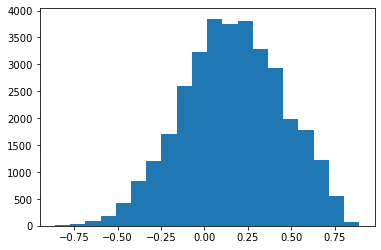

In [16]:
df_daily['food_sameDurTiming_r50_nbrbatch'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[2])
df_daily['food_sameDurTiming_li_li_res'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[3])
df_daily['food_sameDurTiming_nbrbatch'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[4])
df_daily['food_sameDurTiming_lires'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[5])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch','food_sameDurTiming_r50','food_sameDurTiming_nbrbatch']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch','food_sameDurTiming_r50','food_sameDurTiming_nbrbatch',
                 'food_sameDurTiming_tFZ_ALL','food_sameDurTiming_tFZ_ALL_FAKE','food_sameDurTiming_lires']].tail(3))
display(df_daily['food_sameDurTiming_nbrbatch'].value_counts())
plt.hist(df_daily['food_sameDurTiming_r50'], bins=20)
plt.show()

,HenID,level,food_sameDurTiming_r50_nbrbatch_AP,food_sameDurTiming_r50_AP,food_sameDurTiming_nbrbatch_AP,food_sameDurTiming_tFZ_ALL_AP,food_sameDurTiming_tFZ_ALL_FAKE_AP,food_sameDurTiming_lires_AP
0,hen_130,2020-10-05,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN,NaN,[nan],NaN
1,hen_130,2020-10-06,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN,NaN,[nan],NaN
2,hen_130,2020-10-07,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN,NaN,[nan],NaN


,HenID,level,food_sameDurTiming_r50_nbrbatch_AP,food_sameDurTiming_r50_AP,food_sameDurTiming_nbrbatch_AP,food_sameDurTiming_tFZ_ALL_AP,food_sameDurTiming_tFZ_ALL_FAKE_AP,food_sameDurTiming_lires_AP
39379,hen_98,2021-07-22,"(0.01, [240, nan, 0, nan], [[0, 240, 0, 0, 0, ...",0.01,2.0,"[240, nan, 0, nan]","[[0, 240, 0, 0, 0, 240, 0, 0, 0, 0, 37, 240, 2...","[0.5610048012475434, nan, -0.5333333333333333,..."
39380,hen_98,2021-07-23,"(0.23, [217, nan, nan, nan], [[0, 240, 0, 240,...",0.23,1.0,"[217, nan, nan, nan]","[[0, 240, 0, 240, 240, 0, 240, 240, 240, 240, ...","[0.2321101169737553, nan, nan, nan]"
39381,hen_98,2021-07-24,"(0.19, [0, 240, 109, 0], [[0, 0, 0, 0, 0, 0, 2...",0.19,4.0,"[0, 240, 109, 0]","[[0, 0, 0, 0, 0, 0, 240, 240, 0, 240, 240, 240...","[-0.31333333333333335, 0.8864934936708004, 0.4..."


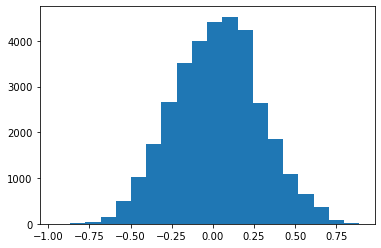

In [17]:
fake_sec_ = 20*60 #20 minutes in second 
df_daily['food_sameDurTiming_r50_nbrbatch_AP'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[2])
df_daily['food_sameDurTiming_li_li_res_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[3])
df_daily['food_sameDurTiming_nbrbatch_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[4])
df_daily['food_sameDurTiming_lires_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[5])

display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AP','food_sameDurTiming_r50_AP','food_sameDurTiming_nbrbatch_AP',
                 'food_sameDurTiming_tFZ_ALL_AP','food_sameDurTiming_tFZ_ALL_FAKE_AP','food_sameDurTiming_lires_AP']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AP','food_sameDurTiming_r50_AP','food_sameDurTiming_nbrbatch_AP',
                 'food_sameDurTiming_tFZ_ALL_AP','food_sameDurTiming_tFZ_ALL_FAKE_AP','food_sameDurTiming_lires_AP']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50_AP'], bins=20)
plt.show()

,HenID,level,food_sameDurTiming_r50_nbrbatch_AB,food_sameDurTiming_r50_AB,food_sameDurTiming_nbrbatch_AB
0,hen_130,2020-10-05,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN
1,hen_130,2020-10-06,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN
2,hen_130,2020-10-07,"(nan, nan, [nan], [nan], nan, nan)",NaN,NaN


,HenID,level,food_sameDurTiming_r50_nbrbatch_AB,food_sameDurTiming_r50_AB,food_sameDurTiming_nbrbatch_AB
39379,hen_98,2021-07-22,"(0.02, [0, 240, nan, nan], [[0, 0, 0, 240, 0, ...",0.02,2.0
39380,hen_98,2021-07-23,"(-0.38, [0, nan, 0, 0], [[0, 0, 240, 240, 240,...",-0.38,3.0
39381,hen_98,2021-07-24,"(-0.06, [0, nan, 97, 0], [[240, 0, 0, 0, 0, 0,...",-0.06,3.0


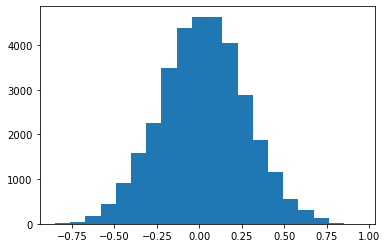

In [18]:
fake_sec_ = -20*60
df_daily['food_sameDurTiming_r50_nbrbatch_AB'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[2])
df_daily['food_sameDurTiming_li_li_res_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[3])
df_daily['food_sameDurTiming_nbrbatch_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[4])
df_daily['food_sameDurTiming_lires_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[5])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AB','food_sameDurTiming_r50_AB','food_sameDurTiming_nbrbatch_AB']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AB','food_sameDurTiming_r50_AB','food_sameDurTiming_nbrbatch_AB']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50_AB'], bins=20)
plt.show()

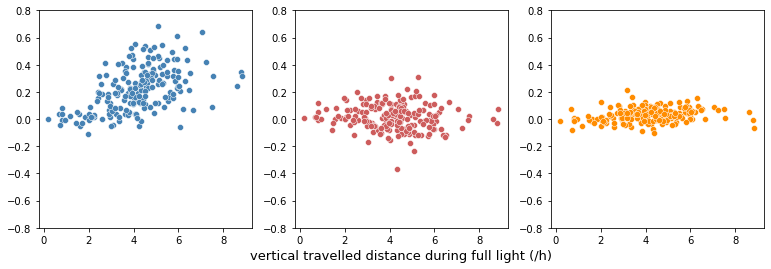

In [19]:
df_BS = df_daily[df_daily['level']<=dt.datetime(2021,3,27)].copy()
pal_ = {'food_sameDurTiming_r50_AB':'darkorange',
        'food_sameDurTiming_r50_AP':'indianred',
        'food_sameDurTiming_r50':'steelblue'}
l=1
c=3
fig = plt.figure(figsize=(13,4)) #/100 si trop grand nbr
df_plt = df_BS.groupby(['HenID']).mean().reset_index()
plt.subplot(l,c,1)
#plt.figure(figsize=(5,4))
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50',
                color=pal_['food_sameDurTiming_r50'])#,  size="size", sizes=(20, 200))
plt.xlabel('')
plt.ylabel('')
#plt.title('food reactivity index')
plt.yticks(fontsize=10)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,2)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AP',
                color=pal_['food_sameDurTiming_r50_AP'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('hens\' mean value')
plt.xlabel('vertical travelled distance during full light (/h)', size=13)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,3)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AB',
                color=pal_['food_sameDurTiming_r50_AB'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('food reactivity index backward push')
plt.xlabel('')
plt.ylim((-0.8, 0.8))
#plt.savefig(os.path.join(path_extracted_data,'dfBS_Raw_VTD_food.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

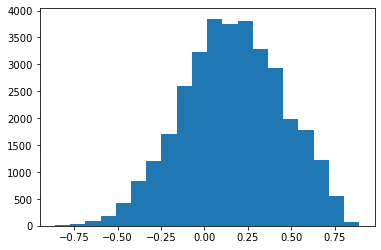

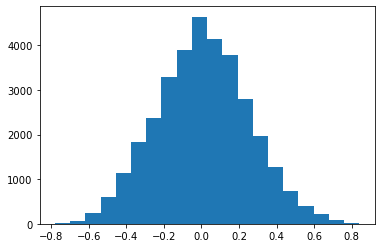

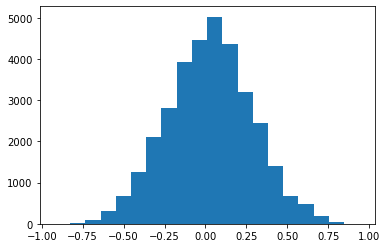

In [20]:
fake_sec_ = 4*60
df_daily['food_sameDurTiming_r50_nbrbatch_4mn'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[2])
df_daily['food_sameDurTiming_li_li_res_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[3])
df_daily['food_sameDurTiming_nbrbatch_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[4])
df_daily['food_sameDurTiming_lires_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_4mn'].map(lambda x: x[5])
plt.hist(df_daily['food_sameDurTiming_r50'], bins=20)
plt.show()

fake_sec_ = 20*60 + 4*60 #20 minutes in second 
df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[2])
df_daily['food_sameDurTiming_li_li_res_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[3])
df_daily['food_sameDurTiming_nbrbatch_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[4])
df_daily['food_sameDurTiming_lires_AP_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP_4mn'].map(lambda x: x[5])
plt.hist(df_daily['food_sameDurTiming_r50_AP_4mn'], bins=20)
plt.show()

fake_sec_ = -20*60+ 4*60
df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[2])
df_daily['food_sameDurTiming_li_li_res_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[3])
df_daily['food_sameDurTiming_nbrbatch_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[4])
df_daily['food_sameDurTiming_lires_AB_4mn'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB_4mn'].map(lambda x: x[5])
plt.hist(df_daily['food_sameDurTiming_r50_AB_4mn'], bins=20)
plt.show()

### add nestbox zone var

#nbr transitions per hour. 
#df_daily['nbr_h_WGopen'] = df_daily['level'].map(lambda x: nbrh_WG_open(x, config))
li_ = ['vertical_travel_distance','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_:
    df_daily[v+'_perh'] = df_daily.apply(lambda x: x[v]/x['nbr_h_per_day'], axis=1)
    df_daily['nbr_stays_1_Zone_perh'] = df_daily.apply(lambda x: x['nbr_stays_1_Zone']/x['nbr_h_WGopen'] if x['nbr_h_WGopen']!=0 else np.nan, axis=1)
df_daily[['vertical_travel_distance_perh','vertical_travel_distance', 'nbr_stays_3_Zone', 'nbr_stays_3_Zone_perh',
        'nbr_h_per_day']].tail(3)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['Total_number_zone']<=2])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['SleepingHeight'] in [0,1], 
                                                              x['nestboxes_related_behavior']<0,
                                                              x['Total_number_zone']<=2,
                                                              x['duration_4_Zone']<15*60])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

#only since 2h start in the morning. ALL DAY! we want mid tiem ONLY MORNING!
df_daily['time_midduratioZ4_h'] = df_daily['mid_cum_Z4_sec'].map(lambda x: x/60/60+2)
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'time_midduratioZ4_h'] = np.nan
plt.hist(df_daily['time_midduratioZ4_h']);
df_daily[['list_Z4', 'mid_cum_Z4_sec','nbr_h_per_day','time_midduratioZ4_h']].head(3)

df_daily['nbr_visit_Z4_Morning_more60sec'] = df_daily['list_ZALL'].map(lambda x: nbr_early_visit_Z4_moreXsec(eval(x)[0:((8-2)*60*60)],
                                                                                                           60))
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['nbr_visit_Z4_Morning_more60sec']);

df_daily['nbr_visit_Z4_Morning'] = df_daily['list_ZALL'].map(lambda x: nbr_early_visit_Z4(eval(x)[0:((8-2)*60*60)]))
plt.hist(df_daily['nbr_visit_Z4_Morning']);

df_daily['duration_until8_inZ4'] = df_daily['list_ZALL'].map(lambda x: sum(list_Z4(eval(x))[0:((8-2)*60*60)]))

df_daily['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec'] = df_daily['list_ZALL'].map(lambda x: nbr_early_visit_Z4_moreXsec(eval(x)[0:((8-2)*60*60)],
                                                                                                           mindur_toaccountforZ4))
plt.hist(df_daily['nbr_visit_Z4_Morning_more'+str(mindur_toaccountforZ4)+'sec']);

In [21]:
len(eval(df_daily['list_ZALL'].iloc[1]))/60/60

9.0

In [22]:
len(eval(df_daily['list_ZALL'].iloc[1])[0:((8-2)*60*60)])/60/60

6.0

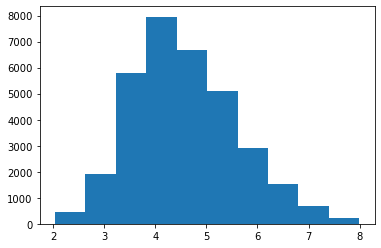

In [23]:
#mid-time Z4 ONLY MORNING
df_daily['mid_cum_Z4_sec_Morning'] = df_daily['list_ZALL'].map(lambda x: mid_cum_Z4_sec(eval(x)[0:((8-2)*60*60)]))
#nan during the days where the artificial light does not start at 2h!
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'mid_cum_Z4_sec_Morning'] = np.nan
df_daily['mid_cum_Z4_h_Morning'] = df_daily['mid_cum_Z4_sec_Morning'].map(lambda x: x/60/60+2)
plt.hist(df_daily[(df_daily['level']>dt.datetime(2020,11,13))]['mid_cum_Z4_h_Morning']);

df_plt = df_daily.groupby(['HenID'])[['nbr_visit_Z4_Morning_more60sec','mid_cum_Z4_h_Morning']].mean().reset_index()
print(df_plt.shape)
display(df_plt.head(3))
plt.scatter(df_plt['nbr_visit_Z4_Morning_more60sec'].tolist(), df_plt['mid_cum_Z4_h_Morning'].tolist());

df_daily[(df_daily['level']>dt.datetime(2020,11,13))&(df_daily['duration_until8_inZ4']<15*60)][['duration_until8_inZ4',
                                                                                                   'HenID','level',
                                                                                                   'mid_cum_Z4_h_Morning',
                                                                                               'nbr_visit_Z4_Morning_more60sec']]

### add order of going to the litter in the morning

#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['FirstTimestamp_2_Zone'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstlitter'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone']) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstlitter_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)

#small verification
df_daily[df_daily['PenID']==10][['order_firstlitter','order_firstlitter_percent','FirstTimestamp_2_Zone','level','PenID',
                                 'HenID']].sort_values(['FirstTimestamp_2_Zone'])

#verify that when an animal slept in the litter then its the first animal to be in litter.
#find such instance (i.e. the day after sleeping height=0!)
display(df_daily[(df_daily['SleepingHeight']==0)&(df_daily['PenID']==10)][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']])
df_daily[(df_daily['level'].isin([dt.datetime(2020,10,6),dt.datetime(2020,10,16),dt.datetime(2020,10,22),
                                  dt.datetime(2020,10,28)]))&(df_daily['HenID']=='hen_143')][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']]
#correct!

### add order of going to the top floor in the evening

#cleaned mvt data
df_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df_init.shape)
df_init.head(3)
#compute last timestamp:
#why: will be usefull to produce other variables, to verify the code and to use it for some zones
df_ = df_init[df_init['Zone']=='5_Zone'].groupby(['HenID', 'date'])['Timestamp'].agg(lambda x: max(list(x))).reset_index()
df_.rename(columns={'Timestamp':'LastTimestampToptier','date':'level'}, inplace=True)
display(df_)
df_daily = pd.merge(df_daily, df_, how='left', on=['HenID','level'])

#ATTENTION: LastTimestampToptier does not mean that the bird stayed there after!! so have to be combined with their sleeping height
#Note that if the hen arrived up at 16h59, but then was kikked away at 17h01: we dont care as long as its sleeping height is the top floor.
#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['LastTimestampToptier'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstgoingup'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier']) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstgoingup_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['LastTimestampToptier_time'] = df_daily['LastTimestampToptier'].map(lambda x: dt.datetime.time(x))
#small verification
df_daily[df_daily['PenID']==10][['order_firstgoingup','order_firstgoingup_percent','LastTimestampToptier','LastTimestampToptier_time',
                                 'level','PenID','HenID','SleepingHeight']].sort_values(['LastTimestampToptier'])
#ISSUE: might not be there anymore!!! should be done with ts!!!!! but then waht if an animal arrive when its dark? bold or not?

#would be 0 if they did not slept up, 1 would mean and 
#in that case, the bird that went up at 6h30 or the one that did not slept in top tier have the save value:30
df_daily['lastminutessleepingUP'] = df_daily.apply(lambda x: x['SleepingHeight']==3 & x['LastTimestampToptier'], axis=1)

#(day_Z5 /day – night_Z5/night) / (day_Z5 /day + night_Z5/night)
def Z5_diurnality(dur_day, dur_night, nbr_h_per_day):
    n = dur_day/nbr_h_per_day - dur_night/(24-nbr_h_per_day)
    p = dur_day/nbr_h_per_day + dur_night/(24-nbr_h_per_day)
    #if never spent time in Z5 then return: neutral nght versus day behavior
    if p==0:
        return 0
    return n/p  

df_daily['Z5diuranility'] = df_daily.apply(lambda x: Z5_diurnality(dur_day=x['duration_5_Zone'],
                                                                   dur_night=x['night_duration_Z5'],
                                                                   nbr_h_per_day=x['nbr_h_per_day']), axis=1)
plt.hist(df_daily['Z5diuranility']);
df_daily[['night_duration_Z5','duration_5_Zone','Z5diuranility']].tail(5)

#coefficient of variation: ratio of standard deviation to mean. np.std(x) / np.mean(x)
df_daily['CVduration'] = df_daily['list_of_durations'].map(lambda x: variation(eval(x)))
display(df_daily[df_daily['CVduration'].isnull()])
df_daily[['list_of_durations','list_of_zones','latency_1_Zone_h','latency_4_Zone_h','latency_2_Zone_h','CVduration']]
plt.hist(df_daily['CVduration']);

# Add daily HA using interpolation

In [29]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
df_HA = df_HA[~df_HA['HenID'].isnull()] #two isntances
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

(844, 60)


HA3    176
HA4    176
HA1    175
HA2    160
HA5    157
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(844, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


In [30]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [65]:
#np.interp:  linear interpolation for monotonically increasing sample points
def inter_HA(HenID, DOA, df_HA, df_FB, str_ha):
    
    if str_ha not in df_HA.columns:
        print('error, specify an exist column name')
        sys.exit()
        
    #available HA days, for that specific hen
    li_DOA = np.array(df_HA[(df_HA['HenID']==HenID)&(~df_HA[str_ha].isnull())]['DOA'].unique())
    if len(li_DOA)==0:
        return np.nan
    mi = min(li_DOA)
    ma = max(li_DOA)
        
    #if its an exact date (never happen, except for last date, which we put to be the date previous the real HA)
    if DOA in li_DOA:
        return df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==DOA)][str_ha].iloc[0]
    
    #if its lower date than the first measured HA, then add the timestamp 0 when they moved to the laying barn, but only if the
    #first health assessment (DOA 173) is available for that bird
    if (DOA<mi) & (str_ha=='weight'):
        x2 = li_DOA[li_DOA > DOA].min()
        if x2==173:
            wdoa119 = df_FB[df_FB['HenID']==HenID]['29-09 weight'].iloc[0]
            return(np.interp(DOA, xp=(119,x2), fp=(wdoa119, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
        
    #if its lower date than the first measured HA, then assume 0 for all when transfer to LB
    if (DOA<mi) & (str_ha=='severity'):
        x2 = li_DOA[li_DOA > DOA].min()
        if x2==173:
            return(np.interp(DOA, xp=(119,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))   

    #if its lower date than the first measured HA (for feather it 215 DOA, then assume 0 for all when transfer to LB
    if (DOA<mi) & (str_ha=='FeatherDamage'):
        x2 = li_DOA[li_DOA > DOA].min()
        if x2==215:
            return(np.interp(DOA, xp=(119,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))   
        
    if DOA<mi:
        return np.nan
        
    #if its at the higher boundery, then add the KBF from that time (can happen with for example early death)
    if DOA>ma:
        return(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==ma)][str_ha].iloc[0])        

    #else if its in between min and max available date with health data return interpolation between thoe two measured HA
    x1 = li_DOA[li_DOA < DOA].max() #largest available HA date below the date we want to find the interpolated HA
    x2 = li_DOA[li_DOA > DOA].min() #smallest available HA date above the date we want to find the interpolated HA
    return(np.interp(DOA, xp=(x1,x2), 
                     fp=(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x1)][str_ha].iloc[0],
                         df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))


print('---------- KBF interpolation computation................')        
df_daily['KBF_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                           df_HA=df_HA, df_FB=df_FB, str_ha='severity'), axis=1)
print('---------- FeatherDamage computation................')
df_daily['FeatherDamage_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='FeatherDamage'), axis=1)
print('---------- weight computation................')
df_daily['weight_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='weight'), axis=1)

---------- KBF interpolation computation................
---------- FeatherDamage computation................
---------- weight computation................


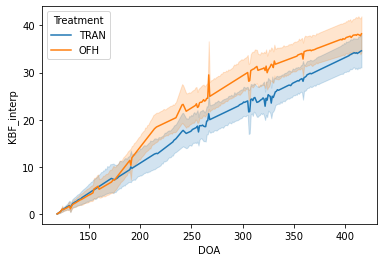

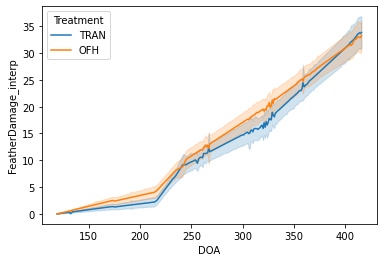

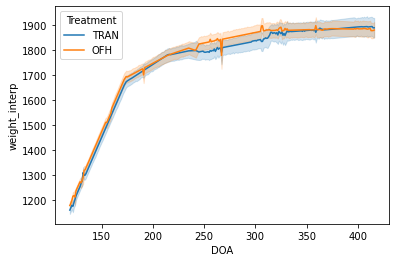

In [66]:
sns.lineplot(x='DOA', y='KBF_interp', hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage_interp',  hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='weight_interp', hue='Treatment', data=df_daily);

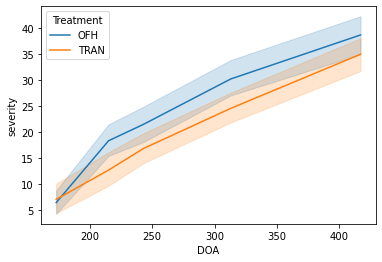

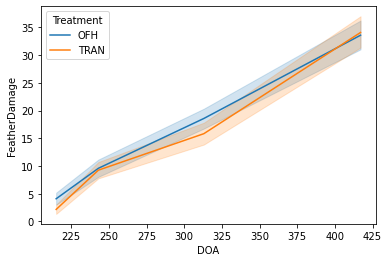

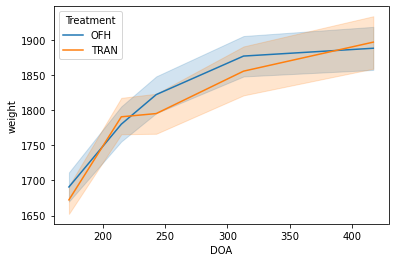

In [67]:
sns.lineplot(x='DOA', y='severity', hue='Treatment', data=df_HA);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage',  hue='Treatment', data=df_HA);
plt.show()
sns.lineplot(x='DOA', y='weight', hue='Treatment', data=df_HA);

# Add daily HA using BLUPS

In [68]:
df_initweight = df_FB[['HenID','29-09 weight']].copy()
df_initweight['DIB'] = 0
df_initweight = df_initweight.rename(columns={'29-09 weight':'weight'})
df_initweight['FeatherDamage'] = 0
df_initweight['severity'] = 0
display(df_initweight.head(3))
df_HA['DIB'] = df_HA['DOA'].map(lambda x: x-118)
df_hablups = df_HA[['HenID','DOA','DIB','severity','FeatherDamage','weight']].copy()
display(df_hablups.head(3))
print(df_initweight.shape, df_hablups.shape)
df_hablups = pd.concat([df_initweight, df_hablups])
print(df_hablups.shape)
display(df_hablups.head(3))
df_hablups = df_hablups[~df_hablups['DIB'].isnull()]
print(df_hablups.shape)
df_hablups.to_csv(os.path.join(path_extracted_data,'df_hablups_all.csv'), index=False, sep=',')
df_ = df_hablups.groupby(['HenID'])['weight'].count().reset_index()
li_hen = df_[df_['weight']>3]['HenID'].tolist()#with at least 3 observation (i.e. 2 as the first one does not really count for severity and feather)
df_hablups[df_hablups['HenID'].isin(li_hen)].to_csv(os.path.join(path_extracted_data,'df_hablups.csv'), index=False, sep=',')

,HenID,weight,DIB,FeatherDamage,severity
0,hen_1,1134.0,0,0,0
1,hen_10,1070.0,0,0,0
2,hen_100,1182.0,0,0,0


,HenID,DOA,DIB,severity,FeatherDamage,weight
0,hen_164,173.0,55.0,0,NaN,1673.8
1,hen_181,243.0,125.0,16,14.0,2206.9
2,hen_82,243.0,125.0,4,8.0,1790.9


(232, 5) (844, 6)
(1076, 6)


,HenID,weight,DIB,FeatherDamage,severity,DOA
0,hen_1,1134.0,0.0,0.0,0,NaN
1,hen_10,1070.0,0.0,0.0,0,NaN
2,hen_100,1182.0,0.0,0.0,0,NaN


(1076, 6)


# Adding (henID;WIB) serie

In [45]:
df_daily['HenID_WIB'] = df_daily.apply(lambda x: x['HenID']+'-WIB'+str(x['WIB']), axis=1)
df_daily[['HenID_WIB','HenID','WIB']].head(5)

,HenID_WIB,HenID,WIB
0,hen_130-WIB1,hen_130,1
1,hen_130-WIB1,hen_130,1
2,hen_130-WIB2,hen_130,2
3,hen_131-WIB1,hen_131,1
4,hen_131-WIB1,hen_131,1


# Correcting food reactivity index

### initial measure

In [46]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_related_behavior_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior'], df_daily['food_related_behavior4'])
df_daily['food_related_behavior_rp_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rp'], df_daily['food_related_behavior_rp4'])
df_daily['food_related_behavior_rm_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rm'], df_daily['food_related_behavior_rm4'])

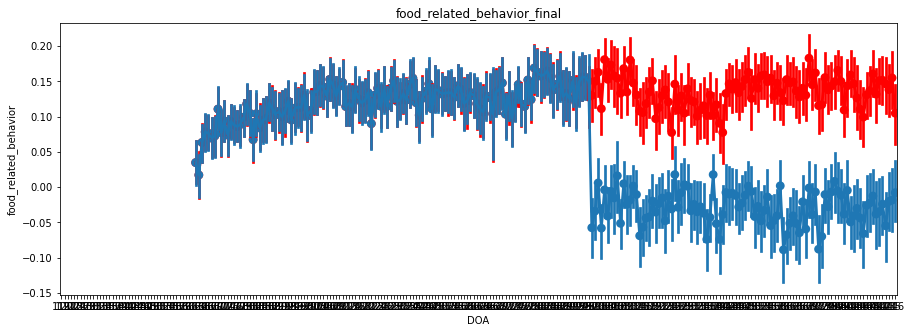

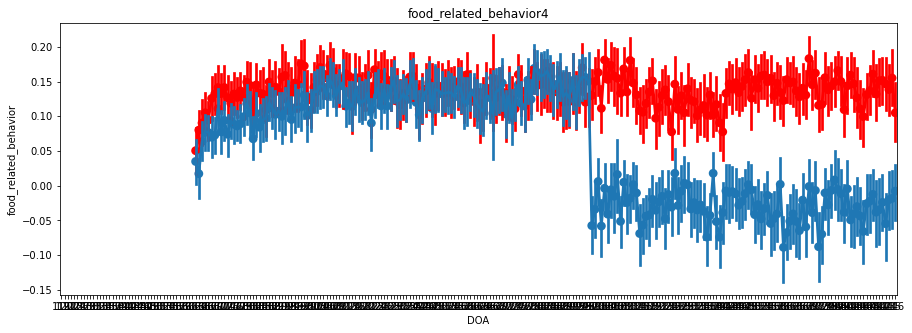

In [47]:
#small verification: CORRECT!
li_food = ['food_related_behavior_final','food_related_behavior4']
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_related_behavior', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [48]:
df_plt = pd.melt(df_daily[df_daily['level']>config.date_consistent_barn_schedule], id_vars=['HenID','WOA','level','PenID'], 
        value_vars=['food_related_behavior_final','food_related_behavior_rp_final','food_related_behavior_rm_final'],
        value_name='food_behavior')
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
display(df_plt.head(3))
#display(df_plt.groupby(['variable'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index())
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index()
#weekly average +-SD of the mean daily food-related behavior across individuals

,HenID,WOA,level,PenID,variable,food_behavior,is_positive
0,hen_131,24,2020-11-14,10,food_related_behavior_final,0.141396,1
1,hen_131,24,2020-11-15,10,food_related_behavior_final,0.156883,1
2,hen_131,24,2020-11-16,10,food_related_behavior_final,-0.225432,0


,variable,level,is_positive
0,food_related_behavior_final,2020-11-14,56.410256
1,food_related_behavior_final,2020-11-15,64.743590
2,food_related_behavior_final,2020-11-16,74.358974


,variable,mean_is_positive,sd_is_positive
0,food_related_behavior_final,76.382719,4.118489
1,food_related_behavior_rm_final,52.853390,6.527107
2,food_related_behavior_rp_final,53.776116,4.594645


In [49]:
df_plt[df_plt['food_behavior']==-1].groupby(['variable','HenID']).count().reset_index().sort_values(['WOA']).tail(20)

,variable,HenID,WOA,level,PenID,food_behavior,is_positive
184,food_related_behavior_rp_final,hen_59,8,8,8,8,8
131,food_related_behavior_rp_final,hen_151,8,8,8,8,8
71,food_related_behavior_rm_final,hen_225,8,8,8,8,8
32,food_related_behavior_rm_final,hen_115,8,8,8,8,8
103,food_related_behavior_rm_final,hen_85,9,9,9,9,9
58,food_related_behavior_rm_final,hen_191,10,10,10,10,10
133,food_related_behavior_rp_final,hen_164,11,11,11,11,11
108,food_related_behavior_rp_final,hen_10,11,11,11,11,11
8,food_related_behavior_final,hen_17,11,11,11,11,11
51,food_related_behavior_rm_final,hen_17,11,11,11,11,11


In [50]:
df_plt[(df_plt['food_behavior']==-1)&(df_plt['HenID']=='hen_173')]

,HenID,WOA,level,PenID,variable,food_behavior,is_positive
59957,hen_173,26,2020-11-29,8,food_related_behavior_rp_final,-1.0,0
59964,hen_173,27,2020-12-06,8,food_related_behavior_rp_final,-1.0,0
59970,hen_173,28,2020-12-12,8,food_related_behavior_rp_final,-1.0,0
59971,hen_173,28,2020-12-13,8,food_related_behavior_rp_final,-1.0,0
59983,hen_173,30,2020-12-26,8,food_related_behavior_rp_final,-1.0,0
...,...,...,...,...,...,...,...
93519,hen_173,58,2021-07-11,8,food_related_behavior_rm_final,-1.0,0
93521,hen_173,58,2021-07-13,8,food_related_behavior_rm_final,-1.0,0
93522,hen_173,58,2021-07-14,8,food_related_behavior_rm_final,-1.0,0
93525,hen_173,59,2021-07-17,8,food_related_behavior_rm_final,-1.0,0


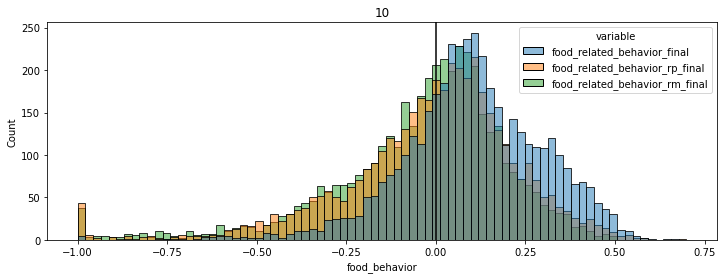

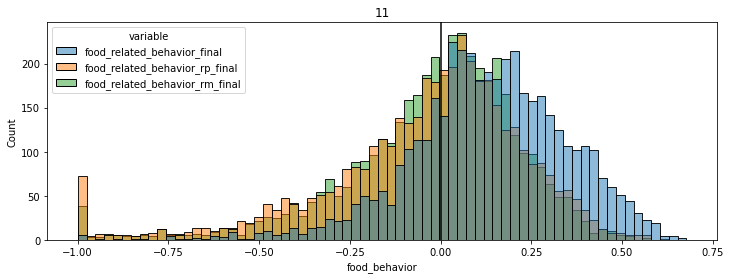

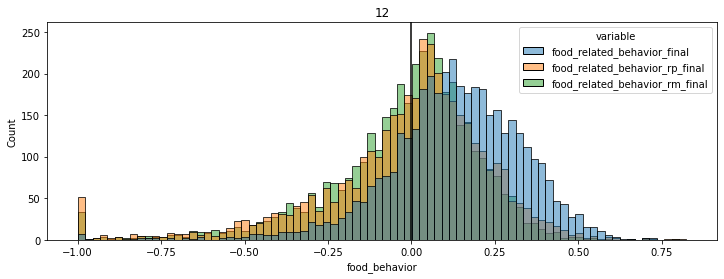

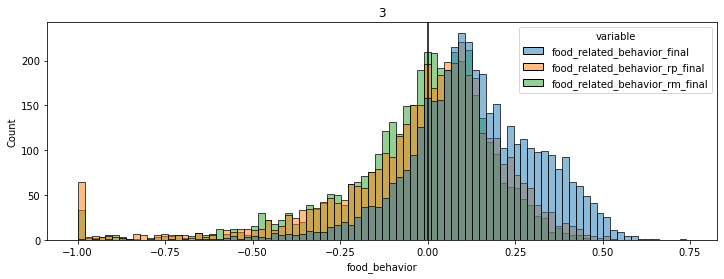

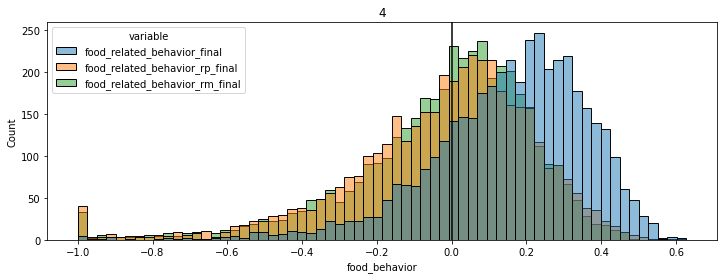

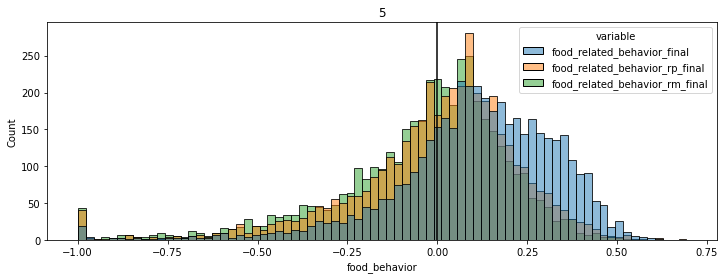

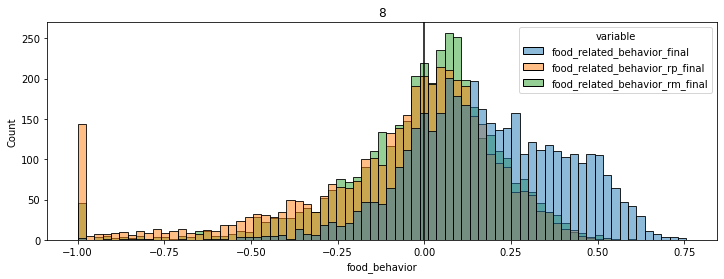

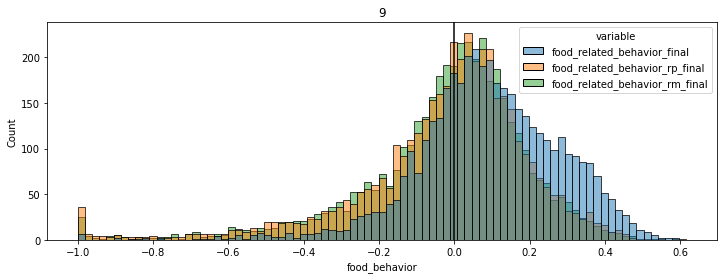

In [51]:
#per pen
pal_ = {'food_related_behavior_rm_final':'darkorange',
        'food_related_behavior_rp_final':'indianred',
        'food_related_behavior_final':'steelblue'}
for penid in df_plt['PenID'].unique():
    plt.figure(figsize=(12,4))
    sns.histplot(df_plt[df_plt['PenID']==penid], x='food_behavior', kde=False, hue='variable');
    plt.axvline(0, color='black');
    plt.title(penid)
    plt.show();

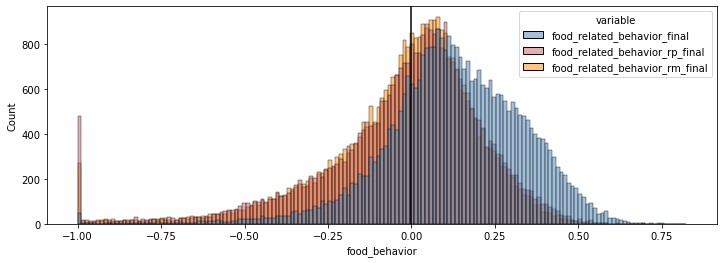

In [52]:
#alltogether
plt.figure(figsize=(12,4))
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.axvline(0, color='black');
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')

In [53]:
#almost non are 0
df_plt[df_plt['food_behavior']==0].shape[0]/df_plt[df_plt['food_behavior']!=0].shape[0]*100

0.019979022026871785

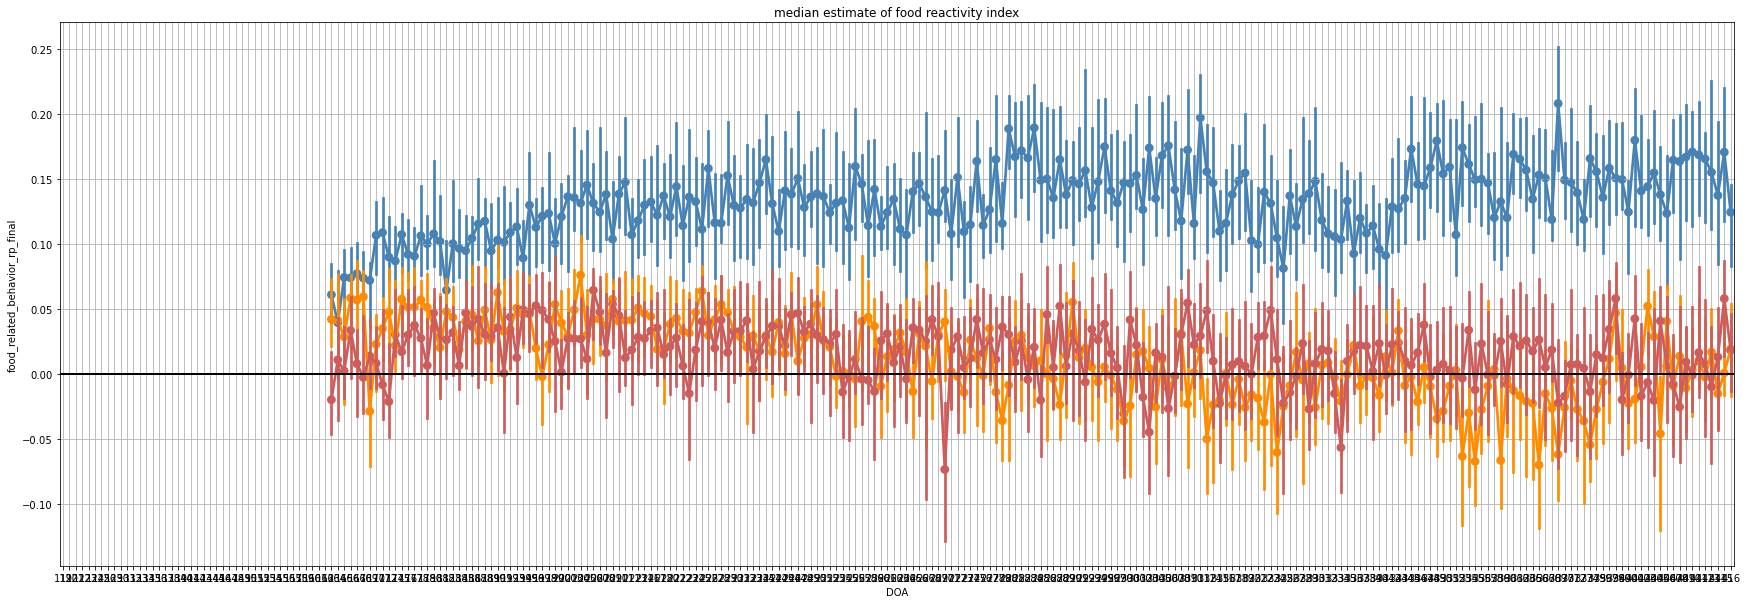

In [54]:
#median
plt.figure(figsize=(30,10))
sns.pointplot(y='food_related_behavior_final', x='DOA', color=pal_['food_related_behavior_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color=pal_['food_related_behavior_rm_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color=pal_['food_related_behavior_rp_final'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('median estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

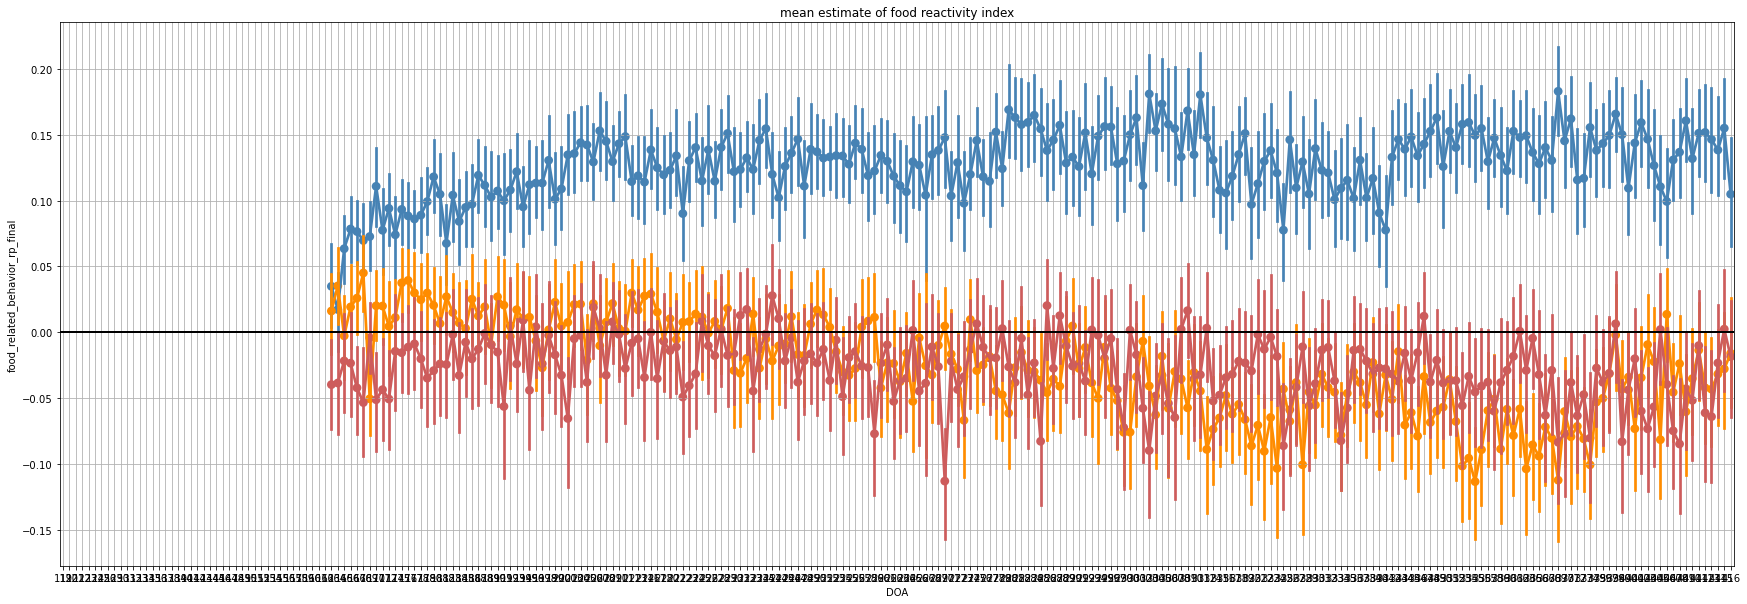

In [55]:
#mean
plt.figure(figsize=(30,10))
sns.pointplot(y='food_related_behavior_final', x='DOA', color=pal_['food_related_behavior_final'], data=df_daily, 
              estimator=np.mean,  s=0.1);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color=pal_['food_related_behavior_rm_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color=pal_['food_related_behavior_rp_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('mean estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI_overtime_mean.png'),dpi=300,format='png',bbox_inches='tight')

### better measure

In [56]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer program timing too
df_daily['food_sameDurTiming_r50_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_sameDurTiming_r50'], df_daily['food_sameDurTiming_r50_4mn'])
df_daily['food_sameDurTiming_r50_AP_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_sameDurTiming_r50_AP'], df_daily['food_sameDurTiming_r50_AP_4mn'])
df_daily['food_sameDurTiming_r50_AB_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_sameDurTiming_r50_AB'], df_daily['food_sameDurTiming_r50_AB_4mn'])

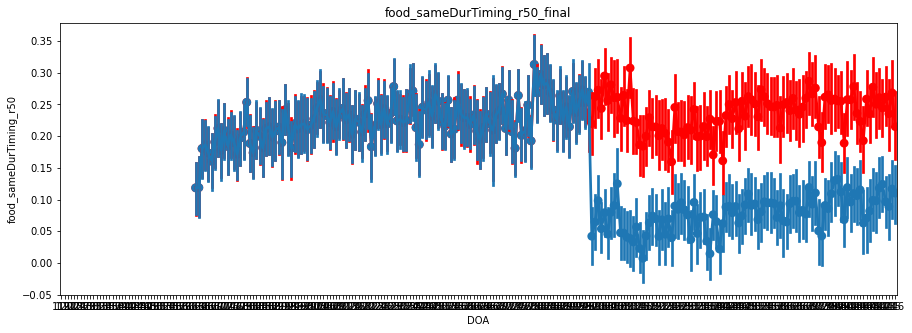

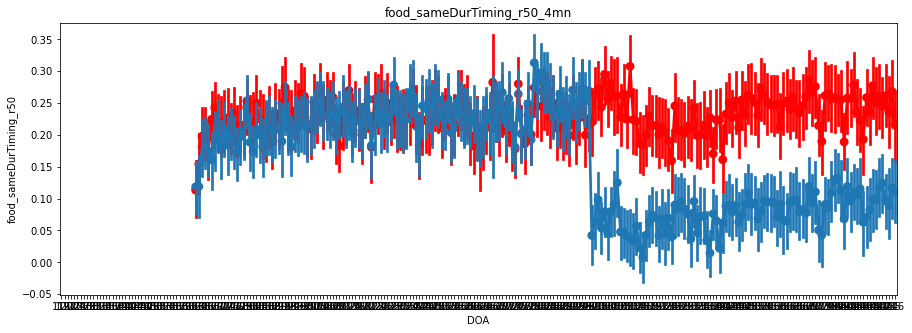

In [57]:
#small verification: CORRECT!
li_food = ['food_sameDurTiming_r50_final','food_sameDurTiming_r50_4mn']
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_sameDurTiming_r50', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [58]:
df_plt = pd.melt(df_daily[df_daily['level']>config.date_consistent_barn_schedule], id_vars=['HenID','WOA','level','PenID'], 
        value_vars=['food_sameDurTiming_r50_final','food_sameDurTiming_r50_AP_final','food_sameDurTiming_r50_AB_final'],
        value_name='food_behavior')
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
display(df_plt.head(3))
#display(df_plt.groupby(['variable'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index())
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index()
#weekly average +-SD of the mean daily food-related behavior across individuals

,HenID,WOA,level,PenID,variable,food_behavior,is_positive
0,hen_131,24,2020-11-14,10,food_sameDurTiming_r50_final,0.31,1
1,hen_131,24,2020-11-15,10,food_sameDurTiming_r50_final,0.18,1
2,hen_131,24,2020-11-16,10,food_sameDurTiming_r50_final,-0.39,0


,variable,level,is_positive
0,food_sameDurTiming_r50_AB_final,2020-11-14,60.897436
1,food_sameDurTiming_r50_AB_final,2020-11-15,53.846154
2,food_sameDurTiming_r50_AB_final,2020-11-16,64.102564


,variable,mean_is_positive,sd_is_positive
0,food_sameDurTiming_r50_AB_final,52.758702,4.936702
1,food_sameDurTiming_r50_AP_final,52.055635,4.403419
2,food_sameDurTiming_r50_final,77.364067,3.720717


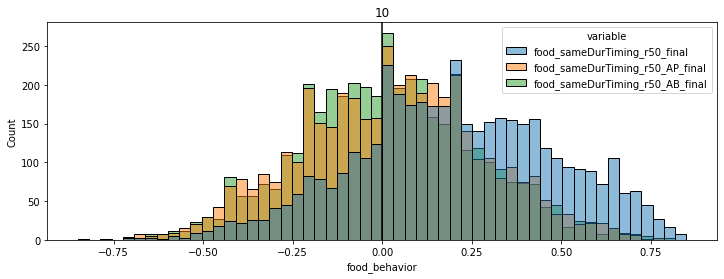

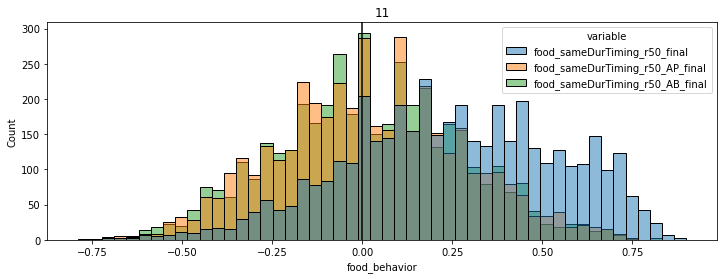

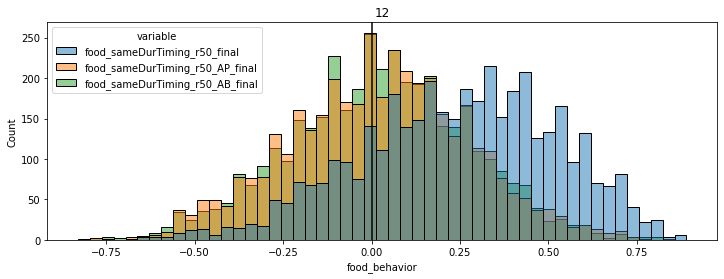

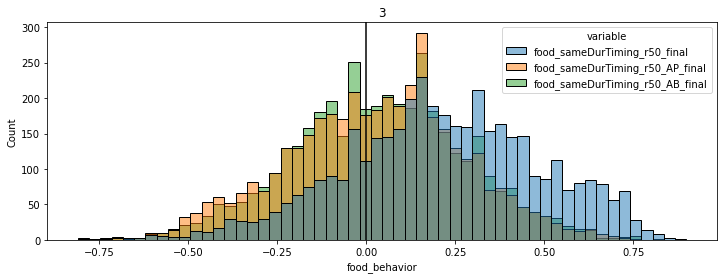

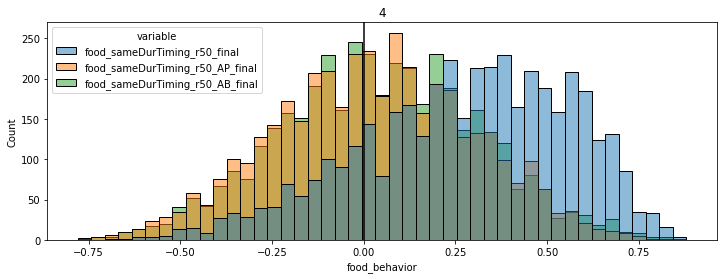

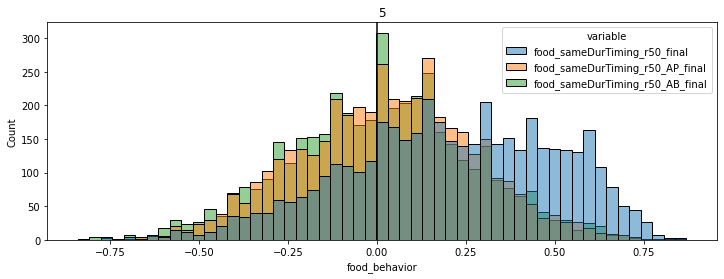

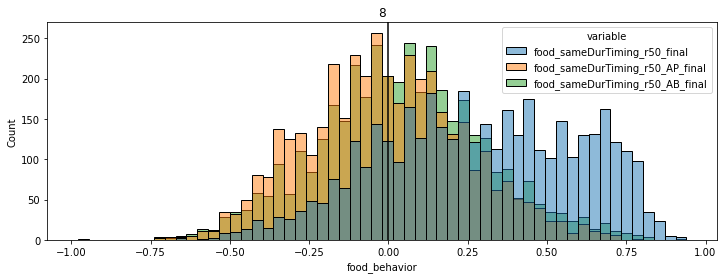

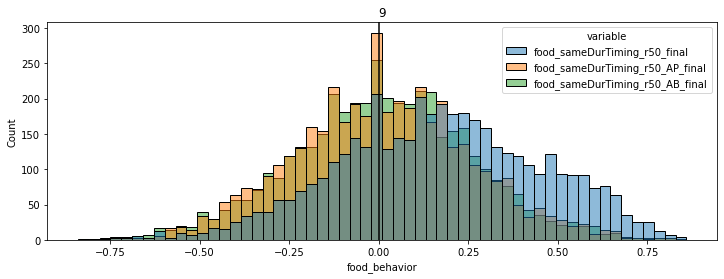

In [59]:
#per pen
for penid in df_plt['PenID'].unique():
    plt.figure(figsize=(12,4))
    pal_ = {'food_sameDurTiming_r50_AB_final':'darkorange',
            'food_sameDurTiming_r50_AP_final':'indianred',
            'food_sameDurTiming_r50_final':'steelblue'}
    sns.histplot(df_plt[df_plt['PenID']==penid], x='food_behavior', kde=False, hue='variable');
    plt.axvline(0, color='black');
    plt.title(penid)
    plt.show();

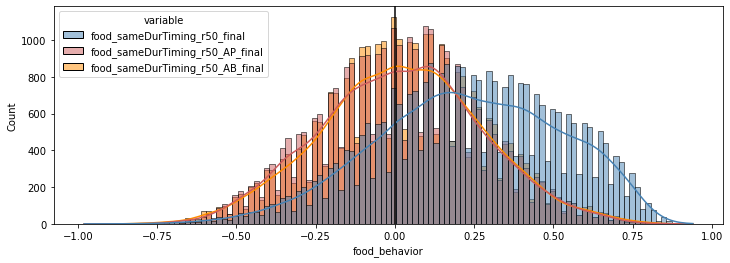

In [60]:
#alltogether
plt.figure(figsize=(12,4))
sns.histplot(df_plt, x='food_behavior', kde=True, hue='variable', palette=pal_);
plt.axvline(0, color='black');
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_density.png'),dpi=300,format='png',bbox_inches='tight')

In [61]:
#nbr of 0
df_plt[df_plt['food_behavior']==0].shape[0]/df_plt[df_plt['food_behavior']!=0].shape[0]*100

1.799603477199939

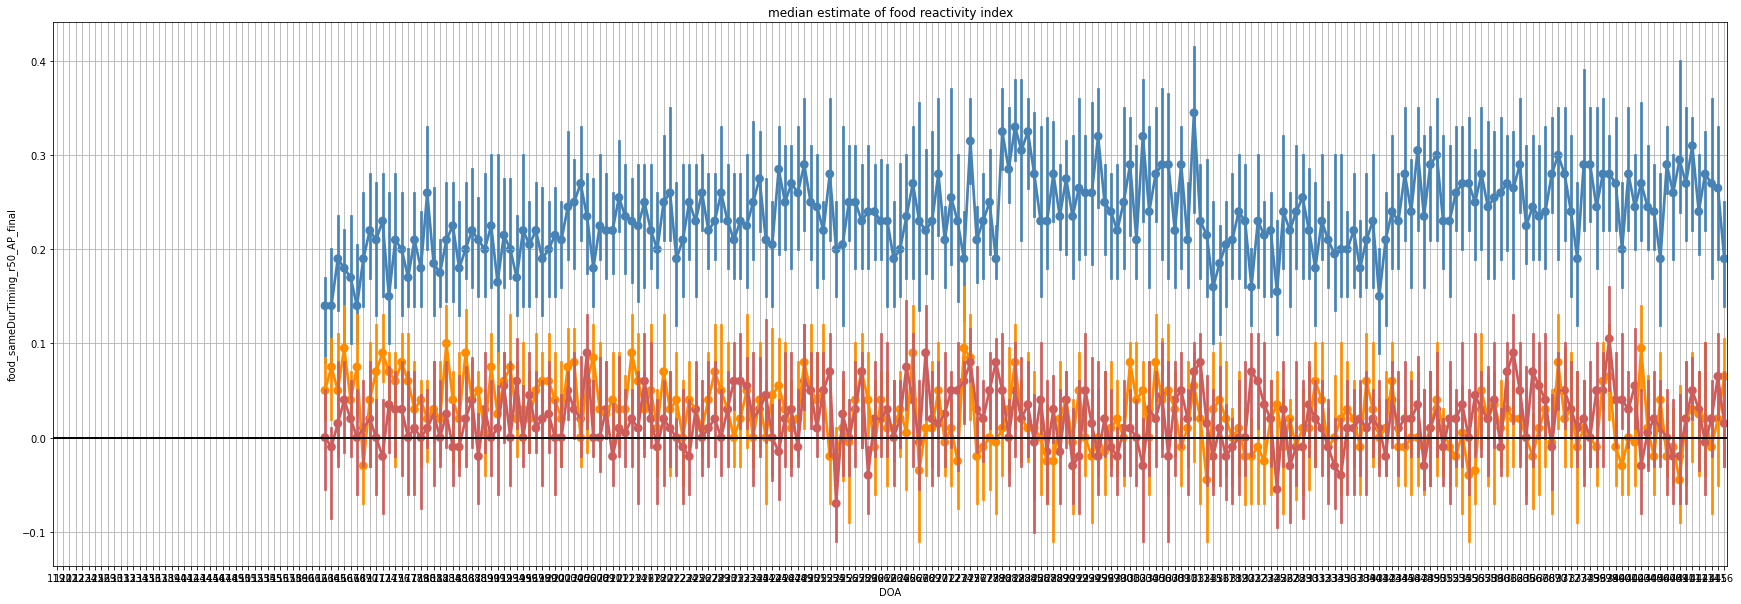

In [62]:
#median
plt.figure(figsize=(30,10))
sns.pointplot(y='food_sameDurTiming_r50_final', x='DOA', color=pal_['food_sameDurTiming_r50_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AB_final', x='DOA', color=pal_['food_sameDurTiming_r50_AB_final'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AP_final', x='DOA', color=pal_['food_sameDurTiming_r50_AP_final'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('median estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

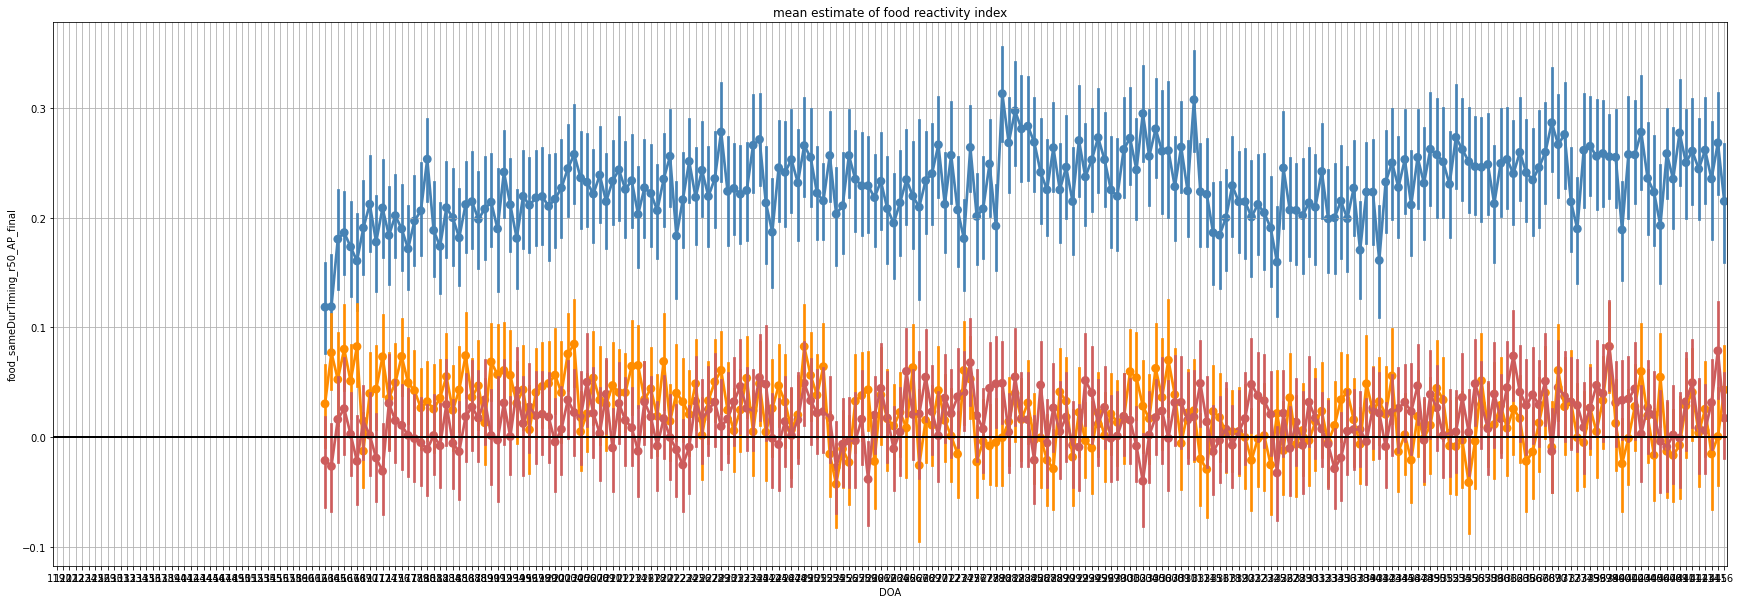

In [63]:
#mean
plt.figure(figsize=(30,10))
sns.pointplot(y='food_sameDurTiming_r50_final', x='DOA', color=pal_['food_sameDurTiming_r50_final'], data=df_daily, 
              estimator=np.mean,  s=0.1);
sns.pointplot(y='food_sameDurTiming_r50_AB_final', x='DOA', color=pal_['food_sameDurTiming_r50_AB_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
sns.pointplot(y='food_sameDurTiming_r50_AP_final', x='DOA', color=pal_['food_sameDurTiming_r50_AP_final'], data=df_daily, 
              estimator=np.mean, s=0.1);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('mean estimate of food reactivity index')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_overtime_mean.png'),dpi=300,format='png',bbox_inches='tight')

# Save

In [69]:
df_daily_ = df_daily.drop(['list_of_zones','list_ZALL',
                           'food_sameDurTiming_r50_nbrbatch']+[i for i in df_daily.columns if ('food' in i) & ('_final' not in i)],axis=1)
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_added.csv'),sep=';',index=False)
print(df_daily_.shape)
df_daily_.head(3)

(39382, 82)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,HenID_WIB,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,KBF_interp,FeatherDamage_interp,weight_interp,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,hen_130-WIB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,hen_130-WIB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,hen_130-WIB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
#save food separately in case
display(df_daily[[i for i in df_daily.columns if ('food' in i)]].tail(3))
df_daily[[i for i in df_daily.columns if ('food' in i)]+['HenID','level','DOA','DIB','WOA','WIB']].to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_FOODvariables.csv'),sep=';',index=False)

,food_related_behavior,food_related_behavior_rp,food_related_behavior_rm,food_related_behavior4,food_related_behavior_rp4,food_related_behavior_rm4,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_tFZ_ALL,food_sameDurTiming_tFZ_ALL_FAKE,...,food_sameDurTiming_tFZ_ALL_FAKE_AB_4mn,food_sameDurTiming_li_li_res_AB_4mn,food_sameDurTiming_nbrbatch_AB_4mn,food_sameDurTiming_lires_AB_4mn,food_related_behavior_final,food_related_behavior_rp_final,food_related_behavior_rm_final,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final
39379,-0.200164,-0.177591,-0.142962,0.193566,-0.439270,-0.124853,"(0.21, [0, 240, nan, 65], [[176, 240, 0, 0, 24...",0.21,"[0, 240, nan, 65]","[[176, 240, 0, 0, 240, 240, 0, 240, 240, 0, 24...",...,"[[145, 0, 0, 240, 240, 240, 240, 0, 0, 0, 7, 2...","[[-1.0, 0, 0, -1.0, -1.0, -1.0, -1.0, 0, 0, 0,...",2.0,"[-0.5866666666666667, 0.6574072059613773, nan,...",0.193566,-0.439270,-0.124853,0.07,-0.20,0.04
39380,-0.401486,0.111936,-0.773116,0.097631,0.089819,-0.566037,"(-0.08, [0, nan, 240, 0], [[0, 0, 240, 240, 24...",-0.08,"[0, nan, 240, 0]","[[0, 0, 240, 240, 240, 0, 240, 240, 240, 240, ...",...,"[[0, 240, 240, 219, 0, 0, 240, 240, 240, 240, ...","[[0, -1.0, -1.0, -1.0, 0, 0, -1.0, -1.0, -1.0,...",2.0,"[-0.7733333333333333, nan, -0.0266666666666666...",0.097631,0.089819,-0.566037,0.12,0.33,-0.40
39381,-0.817838,-0.076385,-0.162700,-0.150950,-0.279975,0.064828,"(-0.25, [0, nan, nan, nan], [[0, 0, 0, 0, 0, 0...",-0.25,"[0, nan, nan, nan]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 240, ...",...,"[[0, 0, 0, 0, 0, 0, 0, 240, 0, 0, 0, 0, 0, 0, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.300813...",3.0,"[0.6311096278797377, nan, -0.49333333333333335...",-0.150950,-0.279975,0.064828,0.25,-0.04,0.31


In [72]:
print([i for i in df_daily.columns if ('food' in i) & ('_final' not in i)])

['food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'food_sameDurTiming_r50_nbrbatch', 'food_sameDurTiming_r50', 'food_sameDurTiming_tFZ_ALL', 'food_sameDurTiming_tFZ_ALL_FAKE', 'food_sameDurTiming_li_li_res', 'food_sameDurTiming_nbrbatch', 'food_sameDurTiming_lires', 'food_sameDurTiming_r50_nbrbatch_AP', 'food_sameDurTiming_r50_AP', 'food_sameDurTiming_tFZ_ALL_AP', 'food_sameDurTiming_tFZ_ALL_FAKE_AP', 'food_sameDurTiming_li_li_res_AP', 'food_sameDurTiming_nbrbatch_AP', 'food_sameDurTiming_lires_AP', 'food_sameDurTiming_r50_nbrbatch_AB', 'food_sameDurTiming_r50_AB', 'food_sameDurTiming_tFZ_ALL_AB', 'food_sameDurTiming_tFZ_ALL_FAKE_AB', 'food_sameDurTiming_li_li_res_AB', 'food_sameDurTiming_nbrbatch_AB', 'food_sameDurTiming_lires_AB', 'food_sameDurTiming_r50_nbrbatch_4mn', 'food_sameDurTiming_r50_4mn', 'food_sameDurTiming_tFZ_ALL_4mn', 'food_sameDurTiming_tFZ_ALL_FAKE_4mn',

In [73]:
df_daily['time_wg_open_sec']

0        21600.0
1        21600.0
2        21600.0
3        21600.0
4        21600.0
          ...   
39377    24000.0
39378    30600.0
39379    30000.0
39380    30000.0
39381    30000.0
Name: time_wg_open_sec, Length: 39382, dtype: float64

#daily var
df_food = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_FOODvariables.csv'), sep=';',
                 parse_dates=['level'],
                 dayfirst=True) 
df_food = df_food[~df_food['level'].isin([dt.datetime(2021,7,25), dt.datetime(2021,5,7)])]
df_food['is_vacc'] = df_food['level'].map(lambda x: x in [dt.datetime(2020,12,30),dt.datetime(2021,3,9)])
#Note: we have corrected for the behaviorual tendency vlaue, but not all its meta data! Therefor:
#not: dt.datetime(2021,5,7) as food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to 
#summer time changed that probably changed the computer program timing too, we would need to take: food_sameDurTiming_r50_4mn
print(df_food.shape)
df_food.head(3)